# Lab 7 - Implementing Single-Label, Multiclass Classification

**Date:** 01 Nov 2023

**Problem Description:** Build a network to classify Reuters newswires into 46 mutually exclusive topics.

The network should have an input layer, two hidden layer and one output layer. The hidden layers should use ReLU activation and have 64 units. The final layer should use Softmax as the activation function. Due to softmax layer the output layer will output 46 probability values.

You will use one-hot encoding (similar to what we used for IMDB Movie Reviews lab) to vectorize the training and test data into binary matrix of shape(dataset-size, 10,0000).

Even the training labels and test labels, which are originally integer labels should be converted into 46 dimensional binary vectors,using one-hot encoding (or categorical encoding). You may use, *to_categorical()* function from *keras.utils* module for this.

Use *categorical_crossentropy* as the loss function during training, and *rmsprop* as the optimizer, and *accuracy* as the monitoring metric.

During training phase, set apart initial 1000 training and test data as validation set for evaluation during the training. Train for 20 epochs with batch_size as 512.

Use the history datastructure to plot the *validation loss* and *training loss* in a single plot using matplotlib. Also do similar plotting for *validation accuracy* and *training accuracy*. Use these plots to identify the epoch for early stopping. Retrain a new neural network from scratch using all the training data for only this no of epochs to avoid overfitting.

Finally evaluate your regularized neural network model on the test data.



***Note:*** Because there are many classes, this problem is an instance of *multi-class classification*. And because each data point should be classified into only one category, the problem is more specifically an instance of *single-label, multiclass classification*. If each data point could belong to multiple categories (in this case, topics), you'd be facing a *multilabel, multiclass classification* problem.  



## Step 1 - Load and Explore the Reuters Dataset
The Reuters dataset is a set of short newswires and their topics, published by Reuters in 1986.

It’s a simple, widely used toy dataset for text classification.

There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [1]:
from keras.datasets import reuters

# the argument num_words=10000 restricts the data to the 10,000 most frequently occuring words found in the data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


In [2]:
# The dataset has 8,982 training examples and 2,246 test examples
print("training data size: ", len(train_data))
print("test data size: ", len(test_data))

training data size:  8982
test data size:  2246


In [3]:
# Each example is a list of integers (word indices)
print(train_data[14])

[1, 4, 113, 23, 133, 6, 433, 226, 7, 1182, 407, 43, 2, 2, 69, 4, 7418, 5, 54, 2395, 521, 562, 6, 1681, 227, 108, 140, 645, 127, 108, 368, 8, 480, 25, 302, 145, 6, 10, 146, 1967, 279, 243, 368, 8, 77, 680, 4, 113, 6, 2258, 10, 73, 238, 715, 5, 1899, 6, 649, 243, 254, 4, 76, 931, 9949, 6, 1823, 16, 233, 1688, 4, 738, 113, 302, 6931, 4, 3380, 24, 54, 2395, 562, 34, 129, 1104, 944, 6, 1366, 1815, 3376, 4, 113, 233, 4, 368, 8, 4, 329, 6822, 27, 37, 38, 431, 484, 884, 568, 24, 4, 521, 562, 299, 45, 306, 194, 572, 1985, 13, 181, 689, 40, 6479, 10, 2, 21, 4, 120, 8, 2, 2, 293, 937, 5, 4071, 60, 2727, 431, 707, 36, 8, 4, 76, 6769, 52, 43, 6006, 4, 37, 38, 41, 2563, 10, 2457, 113, 9, 16, 64, 736, 2221, 5, 6430, 6, 458, 4, 227, 52, 5258, 4, 3023, 76, 4624, 112, 477, 656, 204, 60, 453, 2, 8, 368, 8, 4, 113, 64, 8270, 1873, 2317, 3508, 9, 24, 60, 5, 130, 453, 2192, 114, 7102, 4190, 10, 226, 2771, 7, 4, 227, 77, 8, 4, 204, 60, 421, 164, 68, 6, 19, 44, 35, 15, 145, 348, 1459, 766, 250, 1570, 9, 331, 

In [4]:
# Decoding the examples back to words
word_index = reuters.get_word_index()

# print(word_index)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# print(reverse_word_index)

# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[10]])

print(decoded_newswire)

550378/550378 [==============================] - 0s 0us/step
? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3


In [5]:
# The labels associated with an example is an integer between 0 and 45 - topic index
print(train_labels[14])

19


## Step 2 - Prepare the data
Here we will vectorize the data to transform each sample into a binary vector using one-hot encoding.

In [6]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i,sequence] = 1.
  return results

In [7]:
x_train = vectorize_sequences(train_data) # vectorize training data
x_test = vectorize_sequences(test_data) # vectorize test data

In [8]:
# We will one hot encode the labels as well. One hot encoding is also known as categorical encoding
# To one hot encode the labels, we will embed each integer label as an all-zero vector with a 1 in place of the label index

# label is 3 --> 0001000000.....0
# label is 46 --> 000000 .......1

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels),dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

In [9]:
one_hot_train_labels = to_one_hot(train_labels) # vectorize training labels
one_hot_test_labels = to_one_hot(test_labels) # Vectorize test labels

In [10]:
# Alternatively, we can use the built in function in Keras to do categorical (one hot) encoding
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [11]:
print(one_hot_train_labels[10])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
# Vectorizing our labels
y_train = np.asarray(one_hot_train_labels).astype('float32')
y_test = np.asarray(one_hot_test_labels).astype('float32')

## Step 3 - Building the Network

In [13]:
# The Three Layer Model Definition
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print(partial_x_train)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [16]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 113ms/step - loss: 2.6568 - accuracy: 0.5242 - val_loss: 1.8147 - val_accuracy: 0.6170
Epoch 2/20
16/16 [==============================] - 1s 83ms/step - loss: 1.5258 - accuracy: 0.6776 - val_loss: 1.3854 - val_accuracy: 0.6960
Epoch 3/20
16/16 [==============================] - 1s 90ms/step - loss: 1.1792 - accuracy: 0.7399 - val_loss: 1.2182 - val_accuracy: 0.7300
Epoch 4/20
16/16 [==============================] - 2s 132ms/step - loss: 0.9620 - accuracy: 0.7938 - val_loss: 1.1091 - val_accuracy: 0.7700
Epoch 5/20
16/16 [==============================] - 2s 130ms/step - loss: 0.7971 - accuracy: 0.8317 - val_loss: 1.0384 - val_accuracy: 0.7850
Epoch 6/20
16/16 [==============================] - 1s 82ms/step - loss: 0.6577 - accuracy: 0.8591 - val_loss: 0.9861 - val_accuracy: 0.7870
Epoch 7/20
16/16 [==============================] - 1s 83ms/step - loss: 0.5494 - accuracy: 0.8820 - val_loss: 0.9219 - val_accuracy: 0.8110
Epoch 8/20

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

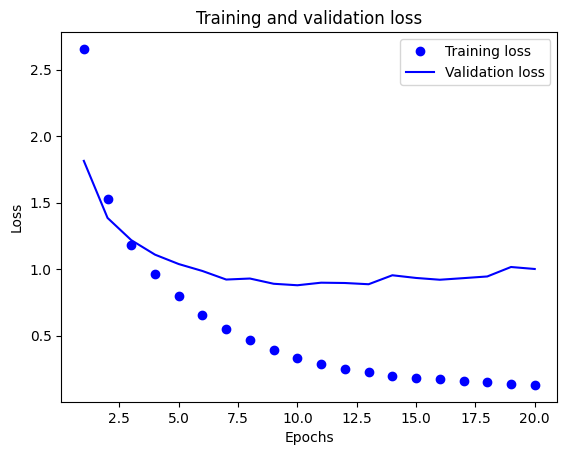

In [18]:
# Plotting the training and validation loss side by side using Matplotlib
import matplotlib.pyplot as plt
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss') # "bo" stands for "blue dot"
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # "b" stands for "solod blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

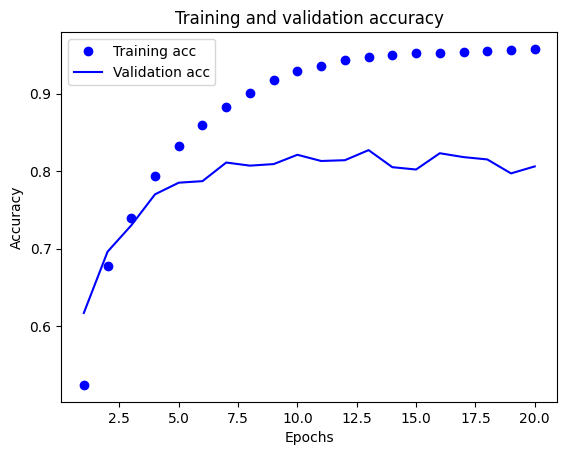

In [19]:
# Plotting the training and validation accuracy side by side using Matplotlib
plt.clf() # clears the figure
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Evaluating the performance on Test Dataset
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 1.0500 - accuracy: 0.7903


In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(x_train, one_hot_train_labels, epochs=6, batch_size=512) # We are stopping early after only 4 epochs

Epoch 1/6
18/18 [==============================] - 1s 44ms/step - loss: 2.5631 - accuracy: 0.5327
Epoch 2/6
18/18 [==============================] - 1s 59ms/step - loss: 1.4496 - accuracy: 0.6880
Epoch 3/6
18/18 [==============================] - 1s 67ms/step - loss: 1.1299 - accuracy: 0.7506
Epoch 4/6
18/18 [==============================] - 1s 69ms/step - loss: 0.9205 - accuracy: 0.8008
Epoch 5/6
18/18 [==============================] - 1s 52ms/step - loss: 0.7730 - accuracy: 0.8304
Epoch 6/6
18/18 [==============================] - 1s 40ms/step - loss: 0.6385 - accuracy: 0.8607


In [23]:
# Evaluating the new model on Test Data
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 0.9875 - accuracy: 0.7716


In [24]:
prediction = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


In [25]:
np.argmax(prediction[0])

3